In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import os
import pickle
import utils
import matplotlib.tri as tri
from matplotlib import rc
import matplotlib.pylab as plt


In [2]:
with open('../result_log/FINALPREDS-1.pkl', 'rb') as f:
    data = pickle.load(f)

print(list(data.keys()))

def get_RFF_PINN_preds(data, key):
    result = data[key]
    seeds = list(result.keys())
    if len(seeds) <1:
        print('no seeds for key: ', key)
        return None
    best_seed = seeds[0]
    for seed in seeds:
        if result[seed]['finallerror'] < result[best_seed]['finallerror']:
            best_seed = seed
    return result[best_seed]['preds']

for key in list(data.keys()):
    preds = get_RFF_PINN_preds(data, key)



['d1poisson_dv11_2pi', 'd1poisson_dv36_2pi', 'd1poisson_dv37_2pi', 'd2poisson_dv1_2pi', 'd2poisson_dv3_2pi', 'd2allencahn_dv11_2pi', 'd1advection_dv38_2pi', 'd1poisson_dv11_1', 'd1poisson_dv36_1_5000', 'd1poisson_dv36_1_10000', 'd1poisson_dv37_1', 'd2allencahn_dv11_1']


In [3]:

equation_dict = {
    'poisson_2d-sin_cos':'u = sin(100x)cos(100y)',
    'poisson_2d-sin_sin':'u = sin(100x)sin(100y)',
    'poisson_2d-sin_add_cos': 'u= sin(6x)sin(20x) + sin(6y)sin(20y) ',
    'allencahn_2d-mix-sincos':'u= (sin(x) + 0.1sin(20x) + cos(100x)) * (sin(y) + 0.1sin(20y) + cos(100y))',
    'advection-sin':'u = sin(x-200t)'
    }


def load_and_predict_2d(prefix, save_name,N_col=200,scale=1):    

    with open(prefix + save_name + '.pkl', 'rb') as f:
        params, log_dict, trick_paras = pickle.load(f)
    if 'N_col' not in list(trick_paras.keys()):
        trick_paras['N_col'] = N_col

    if 'scale' not in list(trick_paras.keys()):
        trick_paras['scale'] = scale

    model, preds = utils.get_model_2d(params, trick_paras)

    return model, preds, log_dict

def load_and_predict_advection(prefix, save_name):    

    with open(prefix + save_name + '.pkl', 'rb') as f:
        params, log_dict, trick_paras = pickle.load(f)

    model, preds = utils.get_model_2d_advection(params, trick_paras)

    return model, preds, log_dict

def get_err(model, preds):
    err = np.sqrt((np.square(preds-model.ute)))
    return err



equation is:  advection-sin
kernel is: Matern52_Cos_1d
equation is:  advection-sin
kernel is: SE_Cos_1d
equation is:  advection-sin
kernel is: SE_1d
equation is:  advection-sin
kernel is: Matern52_1d


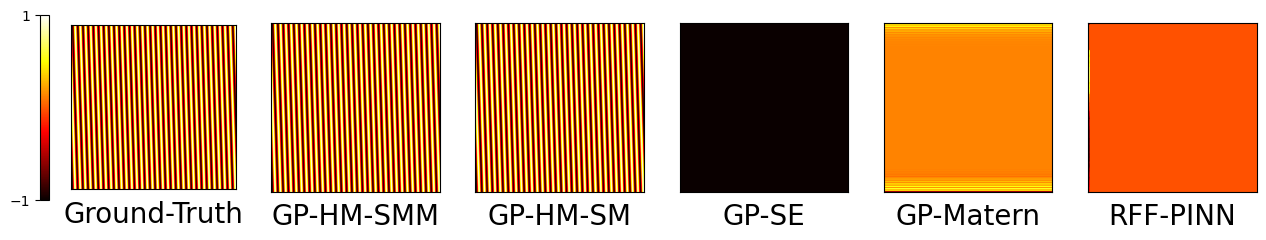

In [4]:
# for advection (x in [0, 2pi])
kernel_list = ['Matern52_Cos_1d','SE_Cos_1d','SE_1d','Matern52_1d']
label_list = ['GP-HM-SMM','GP-HM-SM','GP-SE','GP-Matern', 'RFF-PINN']

# prefix = '../result_log/poisson_1d-sin_cos/kernel_Matern52_Cos_1d/epoch_1000000/Q30/'
save_name = 'llk_weight-200.0-nu-1-Q-30-epoch-1000000-lr-0.0100-freqscale=50-logdet-1-x-2pi-beta-200'

pred_list = []

for kernel_name in kernel_list:
    prefix = '../result_log/advection-sin/kernel_%s/epoch_1000000/Q30/'%(kernel_name)

    model, preds,log_dict = load_and_predict_advection(prefix, save_name)
    preds = np.nan_to_num(preds)
    pred_list.append(preds)

# load RFF-PINNs
RFF_PINN = get_RFF_PINN_preds(data,'d1advection_dv38_2pi').reshape(100,100)

pred_list.append(RFF_PINN)


pred_all = np.concatenate(
    pred_list[:-1]
)

pred_min = min(pred_all.min(),RFF_PINN.min())
pred_max = max(pred_all.max(),RFF_PINN.max())
# pred_max = pred_all.max()
# err_norm = err_max-err_min

imgs = []

fig, axs = plt.subplots(1,6, figsize=(16,3),gridspec_kw={'width_ratios': [1.3, 1,1,1,1,1]})


img =axs[0].imshow(model.ute, cmap="hot")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Ground-Truth',fontsize=20)

imgs.append(img)

for i, _ in enumerate(pred_list):
    img = axs[i+1].imshow(pred_list[i], cmap="hot")
    # img = axs[i+1].imshow(pred_list[i], cmap="jet")

    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_xlabel(label_list[i],fontsize=20)

    imgs.append(img)


fig.colorbar(
    imgs[0], 
    ax=axs[0],
    location='left', 
    ticks=[model.ute.min(), model.ute.max()],
    shrink=0.8,
)
# fig.colorbar(
#     imgs[2], 
#     ax=axs[1:5],
#     location='top', 
#     ticks=[pred_min, pred_max],
#     shrink=0.2,
# )
equation_name =model.trick_paras['equation']
prefix = '../figs/' + equation_name + '/' 
if not os.path.exists(prefix):
    os.makedirs(prefix)
plt.savefig(prefix + 'pred_sum.pdf', dpi=300, bbox_inches='tight')
plt.savefig(prefix + 'pred_sum.png', dpi=300, bbox_inches='tight')

equation is:  poisson_2d-sin_add_cos
kernel is: Matern52_Cos_1d
equation is:  poisson_2d-sin_add_cos
kernel is: SE_Cos_1d
equation is:  poisson_2d-sin_add_cos
kernel is: SE_1d
equation is:  poisson_2d-sin_add_cos
kernel is: Matern52_1d


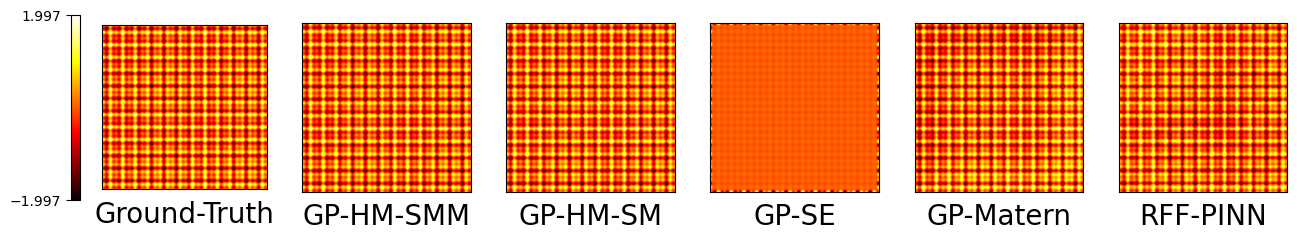

In [6]:
# for poisson 2d (x in [0, 2pi])
kernel_list = ['Matern52_Cos_1d','SE_Cos_1d','SE_1d','Matern52_1d']
label_list = ['GP-HM-SMM','GP-HM-SM','GP-SE','GP-Matern', 'RFF-PINN']

save_name ='llk_weight-200.0-nu-1-Q-30-epoch-1000000-lr-0.0100-freqscale=30-logdet-1-x-2pi'

pred_list = []

for kernel_name in kernel_list:
    prefix = '../result_log/poisson_2d-sin_add_cos/kernel_%s/epoch_1000000/Q30/'%(kernel_name)

    model, preds,log_dict = load_and_predict_2d(prefix, save_name)
    preds = np.nan_to_num(preds)
    pred_list.append(preds)

# load RFF-PINNs
RFF_PINN = get_RFF_PINN_preds(data,'d2poisson_dv3_2pi').reshape(150,150)

pred_list.append(RFF_PINN)


pred_all = np.concatenate(
    pred_list[:-1]
)

pred_min = min(pred_all.min(),RFF_PINN.min())
pred_max = max(pred_all.max(),RFF_PINN.max())
# pred_max = pred_all.max()
# err_norm = err_max-err_min

imgs = []

fig, axs = plt.subplots(1,6, figsize=(16,3),gridspec_kw={'width_ratios': [1.3, 1,1,1,1,1]})


img =axs[0].imshow(model.ute, cmap="hot")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Ground-Truth',fontsize=20)

imgs.append(img)

for i, _ in enumerate(pred_list):
    img = axs[i+1].imshow(pred_list[i], cmap="hot")
    # img = axs[i+1].imshow(pred_list[i], cmap="jet")

    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_xlabel(label_list[i],fontsize=20)

    imgs.append(img)


fig.colorbar(
    imgs[0], 
    ax=axs[0],
    location='left', 
    ticks=[model.ute.min(), model.ute.max()],
    shrink=0.8,
)
# fig.colorbar(
#     imgs[2], 
#     ax=axs[1:5],
#     location='top', 
#     ticks=[pred_min, pred_max],
#     shrink=0.2,
# )
equation_name =model.trick_paras['equation']
prefix = '../figs/' + equation_name + '/' 
if not os.path.exists(prefix):
    os.makedirs(prefix)
plt.savefig(prefix + 'pred_sum.pdf', dpi=300, bbox_inches='tight')
plt.savefig(prefix + 'pred_sum.png', dpi=300, bbox_inches='tight')

equation is:  poisson_2d-sin_sin
kernel is: Matern52_Cos_1d
equation is:  poisson_2d-sin_sin
kernel is: SE_Cos_1d
equation is:  poisson_2d-sin_sin
kernel is: SE_1d
equation is:  poisson_2d-sin_sin
kernel is: Matern52_1d


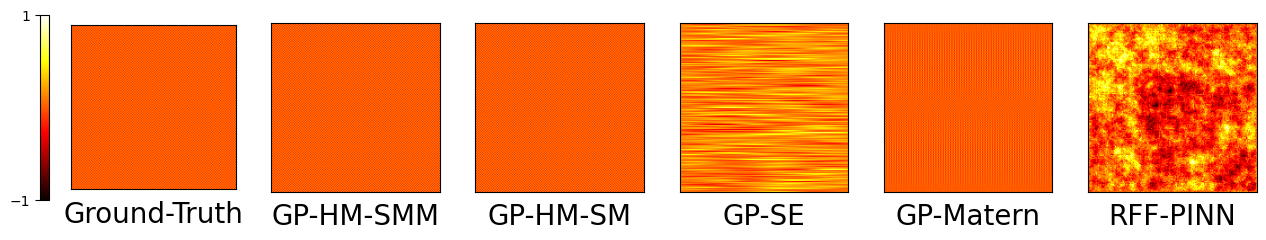

In [8]:
# for poission2d-sin_sin (x in [0, 2pi])
kernel_list = ['Matern52_Cos_1d','SE_Cos_1d','SE_1d','Matern52_1d']
label_list = ['GP-HM-SMM','GP-HM-SM','GP-SE','GP-Matern', 'RFF-PINN']

pred_list = []

save_name ='llk_weight-200.0-nu-1-Q-30-epoch-100000-lr-0.0100-freqscale=20-logdet-1-x-2pi-Ncol-400'

for kernel_name in kernel_list:
    prefix = '../result_log/poisson_2d-sin_sin/kernel_%s/epoch_100000/Q30/'%(kernel_name)

    model, preds,log_dict = load_and_predict_2d(prefix, save_name)
    preds = np.nan_to_num(preds)
    pred_list.append(preds)

# load RFF-PINNs
RFF_PINN = get_RFF_PINN_preds(data,'d2poisson_dv1_2pi').reshape(150,150)

pred_list.append(RFF_PINN)


pred_all = np.concatenate(
    pred_list[:-1]
)

pred_min = min(pred_all.min(),RFF_PINN.min())
pred_max = max(pred_all.max(),RFF_PINN.max())
# pred_max = pred_all.max()
# err_norm = err_max-err_min

imgs = []

fig, axs = plt.subplots(1,6, figsize=(16,3),gridspec_kw={'width_ratios': [1.3, 1,1,1,1,1]})


img =axs[0].imshow(model.ute, cmap="hot")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Ground-Truth',fontsize=20)

imgs.append(img)

for i, _ in enumerate(pred_list):
    img = axs[i+1].imshow(pred_list[i], cmap="hot")
    # img = axs[i+1].imshow(pred_list[i], cmap="jet")

    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_xlabel(label_list[i],fontsize=20)

    imgs.append(img)


fig.colorbar(
    imgs[0], 
    ax=axs[0],
    location='left', 
    ticks=[model.ute.min(), model.ute.max()],
    shrink=0.8,
)
# fig.colorbar(
#     imgs[2], 
#     ax=axs[1:5],
#     location='top', 
#     ticks=[pred_min, pred_max],
#     shrink=0.2,
# )
equation_name =model.trick_paras['equation']
prefix = '../figs/' + equation_name + '/' 
if not os.path.exists(prefix):
    os.makedirs(prefix)
plt.savefig(prefix + 'pred_sum.pdf', dpi=300, bbox_inches='tight')
plt.savefig(prefix + 'pred_sum.png', dpi=300, bbox_inches='tight')

equation is:  allencahn_2d-mix-sincos
kernel is: Matern52_Cos_1d
equation is:  allencahn_2d-mix-sincos
kernel is: SE_Cos_1d
equation is:  allencahn_2d-mix-sincos
kernel is: SE_1d
equation is:  allencahn_2d-mix-sincos
kernel is: Matern52_1d


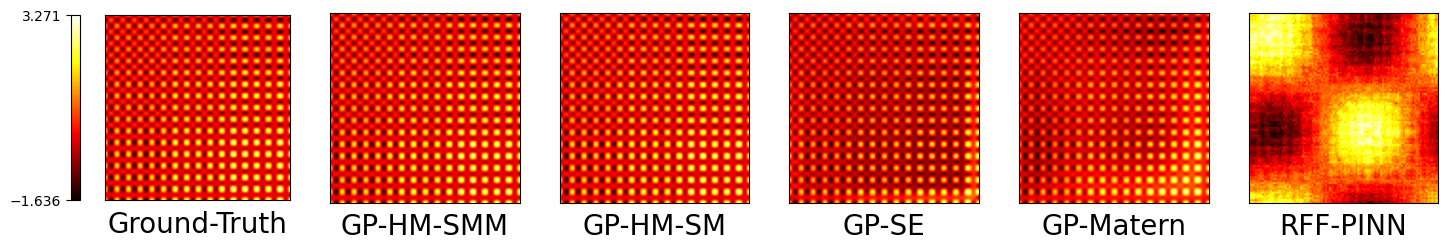

In [9]:
# allencahn_2d-mix-sinco
kernel_list = ['Matern52_Cos_1d','SE_Cos_1d','SE_1d','Matern52_1d']
label_list = ['GP-HM-SMM','GP-HM-SM','GP-SE','GP-Matern', 'RFF-PINN']

pred_list = []

save_name ='llk_weight-200.0-nu-1-Q-30-epoch-3000000-lr-0.0100-freqscale=30-logdet-1'

for kernel_name in kernel_list:
    prefix ='../result_log/allencahn_2d-mix-sincos/kernel_%s/epoch_3000000/Q30/'%(kernel_name)

    model, preds,log_dict = load_and_predict_2d(prefix, save_name)
    preds = np.nan_to_num(preds)
    pred_list.append(preds)

pred_all = np.concatenate(
    pred_list
)


# load RFF-PINNs
RFF_PINN = get_RFF_PINN_preds(data,'d2allencahn_dv11_1').reshape(100,100)

pred_list.append(RFF_PINN)

pred_min = min(pred_all.min(),RFF_PINN.min())
pred_max = max(pred_all.max(),RFF_PINN.max())
# err_norm = err_max-err_min

imgs = []

fig, axs = plt.subplots(1,6, figsize=(18,3),gridspec_kw={'width_ratios': [1.3, 1,1,1,1,1]})


img =axs[0].imshow(model.ute, cmap="hot")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('Ground-Truth',fontsize=20)

imgs.append(img)

for i, kernel_name in enumerate(pred_list):
    img = axs[i+1].imshow(pred_list[i], cmap="hot")
    # img = axs[i+1].imshow(pred_list[i], cmap="jet")

    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_xlabel(label_list[i],fontsize=20)

    imgs.append(img)

fig.colorbar(
    imgs[0], 
    ax=axs[0],
    location='left', 
    ticks=[model.ute.min(), model.ute.max()],
    shrink=0.8,
)
# fig.colorbar(
#     imgs[2], 
#     ax=axs[1:5],
#     location='top', 
#     ticks=[pred_min, pred_max],
#     shrink=0.2,
# )
equation_name =model.trick_paras['equation']
prefix = '../figs/' + equation_name + '/'
if not os.path.exists(prefix):
    os.makedirs(prefix)
plt.savefig(prefix + 'pred_sum.pdf', dpi=300, bbox_inches='tight')
plt.savefig(prefix + 'pred_sum.png', dpi=300, bbox_inches='tight')